**Install Dependencies**

In [1]:
!pip install --quiet newsapi-python
!pip install --quiet transformers
!pip install --quiet torch
!pip install --quiet prophet
!pip install --quiet slack-sdk
!pip install --quiet ftfy  #(FIX TEXT FOR YOU)
!pip install --quiet pandas
!pip install --quiet numpy
!pip install --quiet requests
!pip install --quiet matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.9/293.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.2 MB/s eta 0:00:00


**Import Libraries**

In [15]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import re

from prophet import Prophet
from newsapi import NewsApiClient
from transformers import pipeline
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError


**Load Colab Secrets**

In [16]:
from google.colab import userdata

news_api_key = userdata.get("NEWS_API_KEY")
slack_token = userdata.get("SLACK_BOT_TOKEN")
slack_channel = userdata.get("SLACK_CHANNEL_ID")


**Initialize Clients & Sentiment Model**

In [17]:
# News API client
newsapi = NewsApiClient(api_key=news_api_key)

# Slack client
slack_client = WebClient(token=slack_token)

# FinBERT sentiment pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="yiyanghkust/finbert-tone"
)


Device set to use cpu


**Text Cleaning**

In [18]:
def clean_text(text):
    if not text:
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)        # remove URLs
    text = re.sub(r"[^\x00-\x7F]+"," ", text) # remove emojis/non-ASCII
    text = re.sub(r"\s+"," ", text).strip()   # normalize spaces
    return text

**Fetch News**

In [19]:
def fetch_news(query="Artificial Intelligence", days=30):
    from_date = (dt.datetime.today() - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    to_date = dt.datetime.today().strftime("%Y-%m-%d")

    all_articles = newsapi.get_everything(
        q=query,
        from_param=from_date,
        to=to_date,
        language="en",
        sort_by="relevancy",
        page_size=50,
    )

    articles = []
    for article in all_articles["articles"]:
        articles.append({
            "date": article["publishedAt"][:10],
            "title": article["title"],
            "content": clean_text(article["description"] or article["title"]),
        })

    return pd.DataFrame(articles)

# Fetch last 30 days of AI news
df_news = fetch_news("AI", days=30)
df_news.head()


,date,title,content
0,2025-08-25,AI doesn’t belong in journaling,"in july 2023, i deleted the day one journaling..."
1,2025-08-27,The Era of AI-Generated Ransomware Has Arrived,cybercriminals are increasingly using generati...
2,2025-08-26,AI Is Eliminating Jobs for Younger Workers,new research from stanford provides the cleare...
3,2025-09-10,Melania Trump’s AI Era Is Upon Us,the ever elusive first lady has emerged with a...
4,2025-09-03,Scale AI still exists and it’s suing an ex-emp...,it's been a tumultuous summer for scale ai: me...


**Sentiment Analysis**

In [20]:
def analyze_sentiments(df, confidence_threshold=0.6):
    sentiments = []
    for text in df["content"].fillna(""):
        result = sentiment_pipeline(text[:512])[0]
        label = result["label"]
        score = result["score"]

        if score < confidence_threshold:
            label = "Neutral"
        sentiments.append(label)

    df["sentiment"] = sentiments

    # Map sentiment to numeric
    sentiment_map = {"Positive": 1, "Neutral": 0, "Negative": -1}
    df["sentiment_score"] = df["sentiment"].map(sentiment_map)

    return df

df_news = analyze_sentiments(df_news)
df_news.head()


,date,title,content,sentiment,sentiment_score
0,2025-08-25,AI doesn’t belong in journaling,"in july 2023, i deleted the day one journaling...",Neutral,0
1,2025-08-27,The Era of AI-Generated Ransomware Has Arrived,cybercriminals are increasingly using generati...,Neutral,0
2,2025-08-26,AI Is Eliminating Jobs for Younger Workers,new research from stanford provides the cleare...,Neutral,0
3,2025-09-10,Melania Trump’s AI Era Is Upon Us,the ever elusive first lady has emerged with a...,Positive,1
4,2025-09-03,Scale AI still exists and it’s suing an ex-emp...,it's been a tumultuous summer for scale ai: me...,Neutral,0


**Slack Alert Function**

In [21]:
def send_slack_alert(message, sentiment_label, example_headline=None):
    if example_headline:
        full_message = f"{message} ({sentiment_label})\nTop news: {example_headline}"
    else:
        full_message = f"{message} ({sentiment_label})"

    try:
        slack_client.chat_postMessage(channel=slack_channel, text=full_message)
        print(" Alert sent to Slack!")
    except SlackApiError as e:
        print(f" Slack error: {e.response['error']}")


**Trend Detection**

In [22]:
def detect_shifts_with_example(df_news, recent_days=7, threshold=0.1):
    df_daily = df_news.groupby("date")["sentiment_score"].mean().reset_index()

    if len(df_daily) < recent_days + 1:
        print(" Not enough data to detect shifts.")
        return

    recent_mean = df_daily["sentiment_score"].tail(recent_days).mean()
    historical_mean = df_daily["sentiment_score"].head(len(df_daily) - recent_days).mean()

    # Pick representative headline
    recent_news = df_news.tail(recent_days)
    if len(recent_news) > 0:
        idx = recent_news["sentiment_score"].abs().idxmax()
        example_headline = recent_news.loc[idx, "title"]
        example_sentiment = recent_news.loc[idx, "sentiment"]
    else:
        example_headline = None
        example_sentiment = "Neutral"

    # Determine trend
    if recent_mean > historical_mean + threshold:
        send_slack_alert(" Positive surge detected in AI news sentiment!", example_sentiment, example_headline)
    elif recent_mean < historical_mean - threshold:
        send_slack_alert(" Negative trend detected in AI news sentiment!", example_sentiment, example_headline)
    else:
        send_slack_alert(" No significant change detected (Neutral trend)", example_sentiment, example_headline)

    print(f"Historical mean: {historical_mean:.2f}, Recent mean: {recent_mean:.2f}")


**Prepare for forecasting**

In [23]:
def prepare_forecast_data(df_news):
    forecast_df = df_news.groupby("date")["sentiment_score"].mean().reset_index()
    forecast_df.rename(columns={"date": "ds", "sentiment_score": "y"}, inplace=True)
    return forecast_df

forecast_df = prepare_forecast_data(df_news)
forecast_df.head()


,ds,y
0,2025-08-25,0.000000
1,2025-08-26,0.166667
2,2025-08-27,0.000000
3,2025-08-28,0.000000
4,2025-08-29,-0.500000


**Forecast using Prophet**

INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk1u_zslz/8jg8ezcg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk1u_zslz/65ei_yiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40575', 'data', 'file=/tmp/tmpk1u_zslz/8jg8ezcg.json', 'init=/tmp/tmpk1u_zslz/65ei_yiv.json', 'output', 'file=/tmp/tmpk1u_zslz/prophet_model1yqox7k1/prophet_model-20250923115247.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


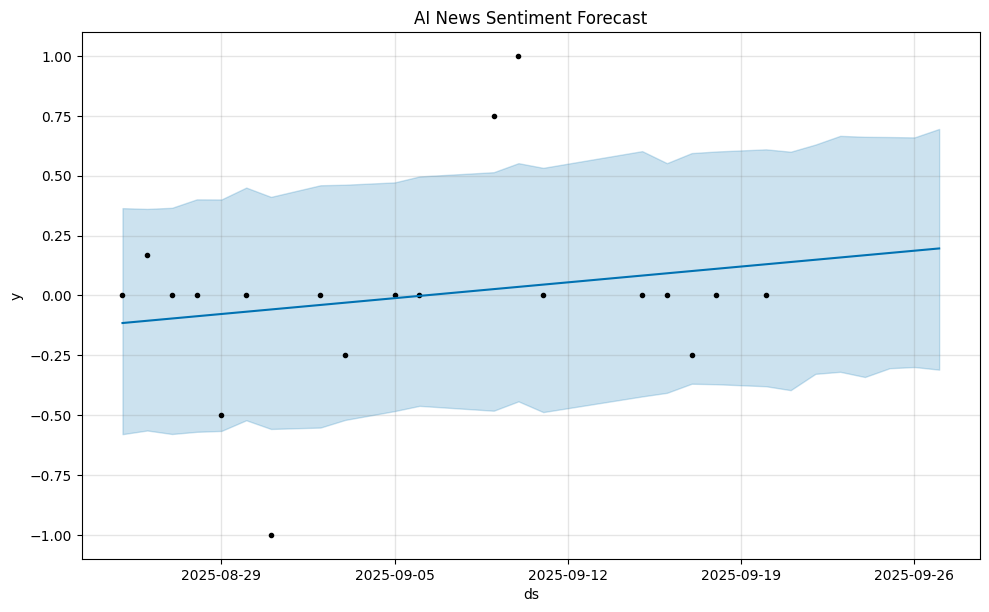

In [24]:
def forecast_trends(forecast_df, periods=7):
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
    model.fit(forecast_df)

    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    model.plot(forecast)
    plt.title("AI News Sentiment Forecast")
    plt.show()
    return forecast

forecast = forecast_trends(forecast_df, periods=7)


**Detect Forecast Shifts**

In [25]:
def detect_forecast_shifts(forecast, recent_days=7, threshold=0.1):
    recent_forecast = forecast.tail(recent_days)["yhat"].mean()
    historical_mean = forecast.head(len(forecast)-recent_days)["yhat"].mean()

    if recent_forecast > historical_mean + threshold:
        trend_message = "Forecast: Positive surge expected in AI news sentiment!"
        trend_sentiment = "Positive"
    elif recent_forecast < historical_mean - threshold:
        trend_message = "Forecast: Negative trend expected in AI news sentiment!"
        trend_sentiment = "Negative"
    else:
        trend_message = "Forecast: No significant change expected (Neutral trend)"
        trend_sentiment = "Neutral"

    top_headlines = df_news.tail(top_n)["title"].tolist()
    send_slack_alert(trend_message, trend_sentiment, top_headlines)
    print(f"Forecast Historical mean: {historical_mean:.2f}, Recent mean: {recent_forecast:.2f}")



**Run Detection**

In [26]:
detect_shifts_with_example(df_news, recent_days=7, threshold=0.1)


 Alert sent to Slack!
Historical mean: -0.07, Recent mean: 0.11


**Save CSV**

In [27]:
df_news.to_csv("ai_news_sentiment.csv", index=False)
print("CSV saved with news and sentiment.")


CSV saved with news and sentiment.
